In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from stljax.formula import *
from stljax.viz import *


## NOTE
`stljax` expects input signals to be of size `[batch_size, time_dim, state_dim]`.
We are working on generalizing this, but right now, it assumes that particular structure.

Additionally, signals are expected to be *time reversed* when passing through an STL formula. Below are some examples showing how yo do this via Expressions. 

In [2]:
@jax.jit
def dynamics_discrete_step(state, control, dt=0.1):
    '''Single integrator 2d dynamics'''
    return state + control * dt

@jax.jit
def simulate_dynamics(controls, state0, dt):
    T = controls.shape[1]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], controls[:,t,:], dt))
    return jnp.concatenate(_states, 1)

# Basic usage

### Using Expressions vs Predicates to define STL formulas


##### Using Expressions
With Expressions, you are essentially defining a 1D signal whose values are the output of a predicate function handled external to the STL robustness computation formula.
Essentially, you process your inputs (e.g., state trajectory) first to get the desired signal, and then you pass it into the formula.

At a high level:\
Suppose `trajectory` is an array of size `[bs, time_steps, state_dim]`

Suppose we have a `get_velocity()`  function and a `get_acceleration()` function:\
 `velocity_value = get_velocity(trajectory)   # [bs, time_steps, 1]`\
 `acceleration_value = get_acceleration(trajectory)   # [bs, time_steps, 1]`

Then, we can define the following two Expressions:\
`velocity_exp = Expression("velocity, velocity_value, False)`\
`acceleration_exp = Expression("acceleration, acceleration_value, False)`

With these two expressions, we can define an STL formula `ϕ = □ (velocity_exp > 5.0) ∨ ◊ (acceleration_exp > 5.0)`\
So the input to `ϕ` is `(velocity_exp, acceleration_exp)`

This means that you need to compute velocity and acceleration values _before_ computing the robustness of `ϕ`. 


##### Using Predicates
With Predicates, this is more true to the STL definition. You pass the predicate function when defining an STL formula, rather than passing the signal that would be the output of a predicate function.
Essentially, you pass your N-D input (e.g., state trajectory) directly into the formula when computing robustness values. 


At a high level:\
Suppose `trajectory` is an array of size `[bs, time_steps, state_dim]`

Suppose we have a `get_velocity()`  function and a `get_acceleration()` function:\
 `velocity_value = get_velocity(trajectory)   # [bs, time_steps, 1]`\
 `acceleration_value = get_acceleration(trajectory)   # [bs, time_steps, 1]`

Then, we can define the following two Predicates:\
`velocity_pred = Predicate("velocity, get_velocity, time_dim, reverse)`\
`acceleration_pred = Predicate("acceleration, get_acceleration, time_dim, reverse)`

With these two expressions, we can define an STL formula `ϕ = □ (velocity_pred > 5.0) ∨ ◊ (acceleration_pred > 5.0)`\
Then the input to `ϕ` is just `trajectory`

**In summary**:\
When using Predicates to define STL formulas, it will extract the velocity and acceleration values _inside_ the robustness computation. Whereas when using Expressions, you need to extract the velocity and acceleration _outside_ of the robustness computation.



(np.float64(-2.8336225271224977),
 np.float64(0.658743929862976),
 np.float64(-2.5266865134239196),
 np.float64(0.6441279292106629))

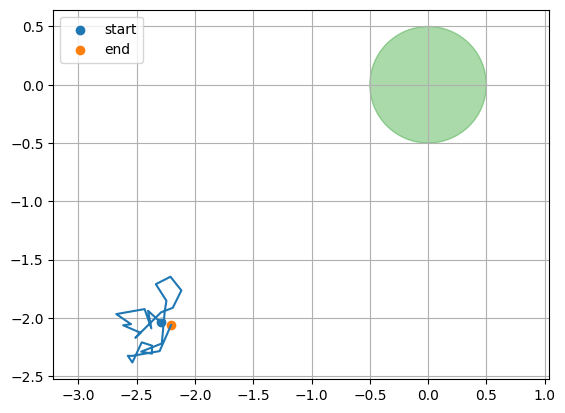

In [3]:
# In this example, using a control sequence to generate a state trajectory
T = 25  # time horizon
dt = 0.1
time_dim = 1 # axis corresponding to time dimension
np.random.seed(123)
controls = jnp.array(np.random.randn(1,T,2))   # generate control sequence
state0 = jnp.array(np.random.randn(1,1,2)) - 1.0   # initial state
states = simulate_dynamics(controls, state0, dt)   # simulate state trajectory

def compute_distance_to_origin(states): 
    return jnp.linalg.norm(states[...,:2], axis=-1, keepdims=True)



# plotting the trajectory (should look noisy/random)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.plot(*states[0].T)
ax.scatter(states[0,0,:1], states[0,0,1:], label="start")
ax.scatter(states[0,-1,:1], states[0,-1,1:], label="end")
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
ax.add_patch(circle1)

plt.xlim([-5,1])
plt.ylim([-4,1])
plt.legend()
plt.grid()
plt.axis("equal")


In [4]:
## Using Expressions

# define expression (with None value)
# NOTE: Expressions are used for setting up predicates. 
#       The values associated with an expression is more for convenience. 
#       You can use a jnp.array directly when evaluating a formula, rather than using an expressiion with values populated.
distance_to_origin_exp = Expression("magnitude", value=None, reverse=False, time_dim=time_dim)
formula_exp = Eventually(distance_to_origin_exp < 0.5)


# this will throw error since the expression value is None.
# (commented out for convenience in running the notebook)
# formula(distance_to_origin_exp)

# setting value for 
states_norm = compute_distance_to_origin(states)   # compute distance to origin, size [1, 26, 1]

distance_to_origin_exp.set_value(states_norm)   # set value for expression


# compute robustness trace and value
# robustness trace
print("Robustness trace: ", formula_exp(distance_to_origin_exp).squeeze())

# robustness value
print("Robustness value: ", formula_exp.robustness(distance_to_origin_exp, time_dim=time_dim).squeeze())


Robustness trace:  [-2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.5186005
 -2.5186005 -2.5186005 -2.5186005 -2.5186005 -2.477519  -2.4112952
 -2.3951554 -2.256407  -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175]
Robustness value:  -2.2557175


/Users/karen/repos/stljax/stljax/formula.py:273: UserWarning: Input Expression "magnitude" is not time reversed! stljax will time-reverse the signal for you...
  warnings.warn("Input Expression \"{input_name}\" is not time reversed! stljax will time-reverse the signal for you...".format(input_name=trace.name))


In [5]:
# if you time reverse the Expression, you will and should get the same answer. if reverse=True, stljax will not automatically reverse the signal for you.
if not distance_to_origin_exp.reverse:
    distance_to_origin_exp.flip_time()   # reverse the time signal. Expressions help keep track of it for you.
formula_exp(distance_to_origin_exp).squeeze()

Array([-2.5186005, -2.5186005, -2.5186005, -2.5186005, -2.5186005,
       -2.5186005, -2.5186005, -2.5186005, -2.5186005, -2.5186005,
       -2.477519 , -2.4112952, -2.3951554, -2.256407 , -2.2557175,
       -2.2557175, -2.2557175, -2.2557175, -2.2557175, -2.2557175,
       -2.2557175, -2.2557175, -2.2557175, -2.2557175, -2.2557175,
       -2.2557175], dtype=float32)

In [6]:
## Using Predicates
# reverse is set to False since we are not assuming the trajectory is already time-reversed
# Within the Predicate definition, the signal will automatically time-reverse the signal is reverse=False. User does not need to handle it.
distance_to_origin_pred = Predicate("magnitude", compute_distance_to_origin, reverse=False, time_dim=time_dim)
formula_pred = Eventually(distance_to_origin_pred < 0.5)

formula_pred(states).squeeze() 

# robustness trace
print("Robustness trace: ", formula_pred(states).squeeze() )

# robustness value
print("Robustness value: ", formula_pred.robustness(states, time_dim=time_dim).squeeze())

Robustness trace:  [-2.569118  -2.569118  -2.569118  -2.569118  -2.569118  -2.569118
 -2.569118  -2.569118  -2.569118  -2.5098376 -2.4085882 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175 -2.2557175
 -2.2557175 -2.2557175]
Robustness value:  -2.2557175


/Users/karen/repos/stljax/stljax/formula.py:282: UserWarning: Input Predicate "magnitude" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))


### Taking gradients

#### Using Expressions

In [7]:

# alternatively, we can just evaluate the robustness (trace) for any jnp.array, not necessarily an expression.
# NOTE: You still need to create an Expression to define a predicate
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX

# NOTE: Since we are not using Expressions to handle the signals, the user must manually keep track of whether or not the signal is time_reversed or not.
# make a random signal
signal = jax.random.uniform(key, shape=(5, T, 2))  # assuming it's already reversed.
signal_norm = compute_distance_to_origin(signal)   # compute distance to origin, size [1, 26, 1]

# and we can take gradients with respect to the signal
def robustness_mean_exp(signal, time_dim, **kwargs):
    # needs to output a scalar 
    signal_norm = compute_distance_to_origin(signal) 
    return formula_exp.robustness(signal_norm, time_dim, **kwargs).mean()


# taking gradient using the true min/max function
jax.grad(robustness_mean_exp)(signal, time_dim, approx_method="true").squeeze() # all zeros expect its -1 at the index where the point (0.5 - signal[index]) is the largest

# taking gradient using a min/max approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well
# logsumexp approximation
jax.grad(robustness_mean_exp)(signal, time_dim, approx_method="logsumexp", temperature=10).squeeze()

# softmax approximation
jax.grad(robustness_mean_exp)(signal, time_dim, approx_method="softmax", temperature=10).squeeze()

# # gmsr approximation (https://arxiv.org/abs/2405.10996)
jax.grad(robustness_mean_exp)(signal, time_dim, approx_method="gmsr", temperature=(1E-6, 1.)).squeeze()


Array([[[-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-2.53600680e-04, -2.17406094e-04],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-6.37109857e-03, -1.65476762e-02],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.000

### Using Predicates

In [8]:

# alternatively, we can just evaluate the robustness (trace) for any jnp.array, not necessarily an expression.
# NOTE: You still need to create an Expression to define a predicate
key = jax.random.PRNGKey(123)  # Random seed is explicit in JAX

# NOTE: Since we are not using Expressions to handle the signals, the user must manually keep track of whether or not the signal is time_reversed or not.
# make a random signal
signal = jax.random.uniform(key, shape=(5, T, 2))  # assuming it's already reversed.
distance_to_origin_pred = Predicate("magnitude", compute_distance_to_origin, reverse=True, time_dim=time_dim)
formula_pred = Eventually(distance_to_origin_pred < 0.5)

# and we can take gradients with respect to the signal
def robustness_mean_pred(signal, time_dim, **kwargs):
    # needs to output a scalar 
    return formula_pred.robustness(signal, time_dim, **kwargs).mean()

# taking gradient using the true min/max function
jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="true") # all zeros expect its -1 at the index where the point (0.5 - signal[index]) is the largest

# taking gradient using a min/max approximation method (specify method and temperature), and the gradients should be "spread" to other indices as well
# logsumexp approximation
jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="logsumexp", temperature=10)

# softmax approximation
jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="softmax", temperature=10)

# # gmsr approximation (https://arxiv.org/abs/2405.10996)
jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="gmsr", temperature=(1E-6, 1.))


Array([[[-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-2.53600680e-04, -2.17406094e-04],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00],
        [-6.37109857e-03, -1.65476762e-02],
        [-0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.000

In [9]:
# check if we get the same answer with both approaches.
(~jnp.isclose(jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="true"), jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="true"))).sum(),\
(~jnp.isclose(jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="logsumexp", temperature=10), jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="logsumexp", temperature=10))).sum(),\
(~jnp.isclose(jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="softmax", temperature=10), jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="softmax", temperature=10))).sum(),\
(~jnp.isclose(jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="gmsr", temperature=(1E-6, 1.)), jax.grad(robustness_mean_pred)(signal, time_dim, approx_method="gmsr", temperature=(1E-6, 1.)))).sum()

(Array(0, dtype=int32),
 Array(0, dtype=int32),
 Array(0, dtype=int32),
 Array(0, dtype=int32))

## Gradient descent to optimize control inputs

Now, we can perform gradient descent on the control inputs to make progress towards the formula being true.

### Using Expressions

In [10]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
time_dim = 1
umax = 1.0  # max control limit

controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.ones(2).reshape([1,1,2]) * 3.
obstacle_center = jnp.ones([1,1,2]) * 2.


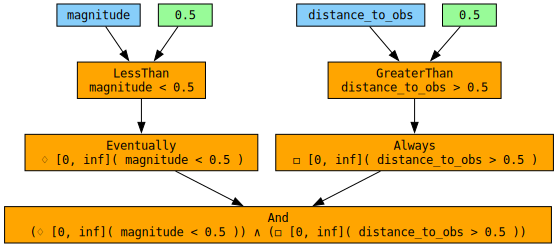

In [11]:
# defining formula
distance_to_origin = Expression("magnitude", None, False)
distance_to_obstacle = Expression("distance_to_obs", None, False)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)
formula = reach & avoid

make_stl_graph(formula)


In [12]:
def loss(controls, state0, umax, dt, coeffs=[1., 0.1, 5.], approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse along time dimension
    traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj_reversed, axis=-1, keepdims=True)
    distance_to_obstacle_signal = jnp.linalg.norm(traj_reversed - obstacle_center, axis=-1, keepdims=True)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    loss_robustness = jax.nn.relu(-formula.robustness(input_signal, time_dim=1, approx_method=approx_method, temperature=temperature)).mean()
    loss_control_smoothness = (jnp.diff(controls, axis=1)**2).sum(-1).mean()  # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits

@jax.jit
def true_robustness(controls, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
    # compute distance_to_origin and distance_to_obstacle
    distance_to_origin_signal = jnp.linalg.norm(traj_reversed, axis=-1, keepdims=True)
    distance_to_obstacle_signal = jnp.linalg.norm(traj_reversed - obstacle_center, axis=-1, keepdims=True)
    # loss functions
    input_signal = (distance_to_origin_signal, distance_to_obstacle_signal)
    return formula.robustness(input_signal, time_dim=1).mean()

def temperature_schedule(i, i_max, start_temp, end_temp, scale=5):
    i_ = i 
    center = i_max / 2
    return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
loss(controls, state0, umax, dt), loss(controls, state0, umax, dt, approx_method="softmax", temperature=5)

(Array(6.64312, dtype=float32), Array(7.0071645, dtype=float32))

In [13]:
states_ = [simulate_dynamics(controls, state0, dt)]
lr = 0.5 # learning rate
approx_method = "logsumexp"
n_steps = 1000   # number of gradient steps
n_steps_extra = 10
coeffs = [1., 0.1, 5.]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(lambda controls, temperature: jax.grad(loss, 0)(controls, state0, umax, dt, coeffs, approx_method, temperature))
# temperature schedule parameters
start_temp = 50
end_temp = 500
scale = 5


In [14]:
for i in range(n_steps):
    temperature = temperature_schedule(i, n_steps, start_temp, end_temp, scale)
    g = grad_jit(controls, temperature)   # take gradient
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g * jnp.ones_like(g) * lr
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f"%(i, true_robustness(controls, state0, dt), loss(controls, state0, umax, dt, coeffs=[0., 1., 0.]), loss(controls, state0, umax, dt, coeffs=[0., 0., 1.])))

  0 -- true robustness: -3.23   smoothness: 4.81    control limits: 0.52
 50 -- true robustness: -1.02   smoothness: 0.79    control limits: 0.09
100 -- true robustness: -0.45   smoothness: 0.46    control limits: 0.09
150 -- true robustness: 0.04   smoothness: 0.16    control limits: 0.00
200 -- true robustness: 0.04   smoothness: 0.11    control limits: 0.00
250 -- true robustness: 0.04   smoothness: 0.08    control limits: 0.00
300 -- true robustness: 0.04   smoothness: 0.05    control limits: 0.00
350 -- true robustness: 0.04   smoothness: 0.04    control limits: 0.00
400 -- true robustness: 0.04   smoothness: 0.03    control limits: 0.00
450 -- true robustness: 0.04   smoothness: 0.03    control limits: 0.00
500 -- true robustness: 0.04   smoothness: 0.02    control limits: 0.00
550 -- true robustness: 0.04   smoothness: 0.02    control limits: 0.00
600 -- true robustness: 0.03   smoothness: 0.01    control limits: 0.00
650 -- true robustness: 0.03   smoothness: 0.01    control li

Text(0, 0.5, 'Controls')

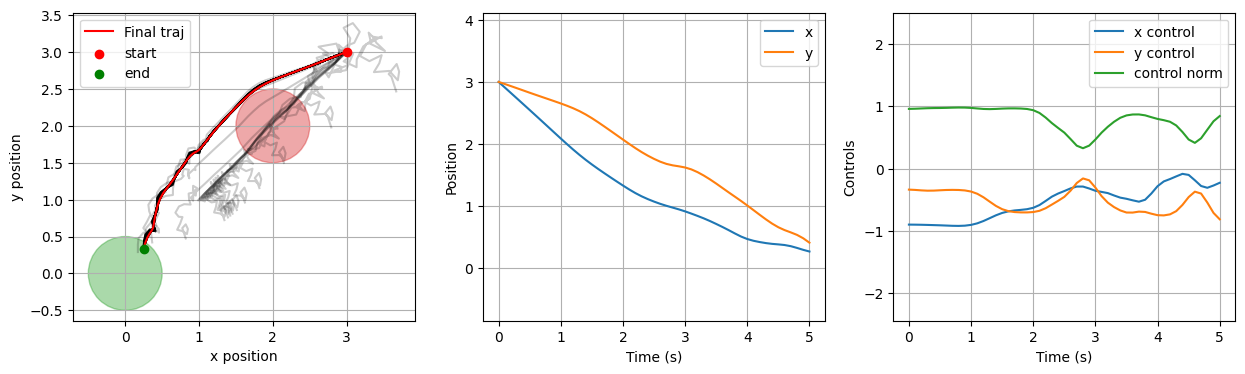

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0,0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

[ax.plot(*s[0].T, color="k", alpha=0.2) for s in states_[::10]]
[ax.plot(*s[0].T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,0,:1], states_[-1][0,0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][0,-1,:1], states_[-1][0,-1,1:], zorder=10, label="end", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][0,:-1,:1], label="x")
ax.plot(ts, states_[-1][0,:-1,1:], label="y")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[0,:,:1], label="x control")
ax.plot(ts, controls[0,:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


### Using Predicates

In [16]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
time_dim = 1
umax = 1.0  # max control limit

controls = jnp.array(np.random.randn(1,T,2))
state0 = jnp.ones(2).reshape([1,1,2]) * 3.
obstacle_center = jnp.ones([1,1,2]) * 2.


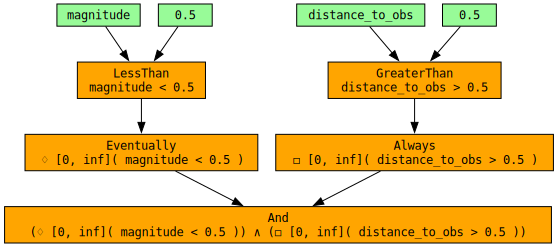

In [17]:
# defining formula

def compute_distance_to_point(states, point):
    return jnp.linalg.norm(states[...,:2] - point, axis=-1, keepdims=True)

def compute_distance_to_origin(states): 
    return compute_distance_to_point(states, jnp.zeros(2))



distance_to_origin = Predicate("magnitude", compute_distance_to_origin, time_dim=1, reverse=False)
distance_to_obstacle = Predicate("distance_to_obs", lambda x: compute_distance_to_point(x, obstacle_center), time_dim=1, reverse=False)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)
formula = reach & avoid

make_stl_graph(formula)


In [18]:
def loss(controls, state0, umax, dt, coeffs=[1., 0.1, 5.], approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    loss_robustness = jax.nn.relu(-formula.robustness(traj, time_dim=1, approx_method=approx_method, temperature=temperature)).mean()
    loss_control_smoothness = (jnp.diff(controls, axis=1)**2).sum(-1).mean()  # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits

@jax.jit
def true_robustness(controls, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    return formula.robustness(traj, time_dim=1).mean()

def temperature_schedule(i, i_max, start_temp, end_temp, scale=5):
    i_ = i 
    center = i_max / 2
    return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
loss(controls, state0, umax, dt), loss(controls, state0, umax, dt, approx_method="softmax", temperature=5)

/Users/karen/repos/stljax/stljax/formula.py:282: UserWarning: Input Predicate "magnitude" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))
/Users/karen/repos/stljax/stljax/formula.py:353: UserWarning: Input Predicate "distance_to_obs" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))


(Array(6.64312, dtype=float32), Array(7.267382, dtype=float32))

In [19]:
states_ = [simulate_dynamics(controls, state0, dt)]
lr = 0.5 # learning rate
approx_method = "logsumexp"
n_steps = 1000   # number of gradient steps
n_steps_extra = 10
coeffs = [1., 0.1, 5.]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(lambda controls, temperature: jax.grad(loss, 0)(controls, state0, umax, dt, coeffs, approx_method, temperature))
# temperature schedule parameters
start_temp = 50
end_temp = 500
scale = 5

In [20]:
for i in range(n_steps):
    temperature = temperature_schedule(i, n_steps, start_temp, end_temp, scale)
    g = grad_jit(controls, temperature)   # take gradient
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g * jnp.ones_like(g) * lr
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f"%(i, true_robustness(controls, state0, dt), loss(controls, state0, umax, dt, coeffs=[0., 1., 0.]), loss(controls, state0, umax, dt, coeffs=[0., 0., 1.])))

/Users/karen/repos/stljax/stljax/formula.py:353: UserWarning: Input Predicate "distance_to_obs" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))
/Users/karen/repos/stljax/stljax/formula.py:282: UserWarning: Input Predicate "magnitude" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))
/Users/karen/repos/stljax/stljax/formula.py:353: UserWarning: Input Predicate "distance_to_obs" is not time reversed. Reversing the signal now...
  warnings.warn("Input Predicate \"{input_name}\" is not time reversed. Reversing the signal now...".format(input_name=self.lhs.name))
/Users/karen/repos/stljax/stljax/formula.py:282: UserWarning: Input Predicate "magnitude" is not time reversed. Reversing the signal now...
  warnings.warn("Input 

  0 -- true robustness: -3.23   smoothness: 4.81    control limits: 0.52
 50 -- true robustness: -1.02   smoothness: 0.79    control limits: 0.09
100 -- true robustness: -0.49   smoothness: 0.46    control limits: 0.09
150 -- true robustness: 0.03   smoothness: 0.17    control limits: 0.00
200 -- true robustness: 0.03   smoothness: 0.11    control limits: 0.00
250 -- true robustness: 0.03   smoothness: 0.08    control limits: 0.00
300 -- true robustness: 0.03   smoothness: 0.06    control limits: 0.00
350 -- true robustness: 0.03   smoothness: 0.04    control limits: 0.00
400 -- true robustness: 0.03   smoothness: 0.03    control limits: 0.00
450 -- true robustness: 0.03   smoothness: 0.03    control limits: 0.00
500 -- true robustness: 0.03   smoothness: 0.02    control limits: 0.00
550 -- true robustness: 0.03   smoothness: 0.02    control limits: 0.00
600 -- true robustness: 0.03   smoothness: 0.01    control limits: 0.00
650 -- true robustness: 0.03   smoothness: 0.01    control li

Text(0, 0.5, 'Controls')

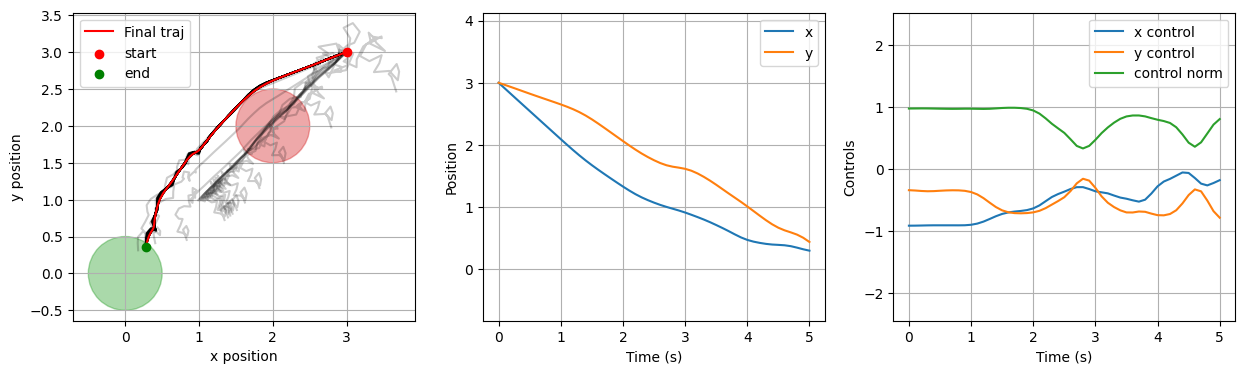

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.5, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0,0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

[ax.plot(*s[0].T, color="k", alpha=0.2) for s in states_[::10]]
[ax.plot(*s[0].T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,0,:1], states_[-1][0,0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][0,-1,:1], states_[-1][0,-1,1:], zorder=10, label="end", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][0,:-1,:1], label="x")
ax.plot(ts, states_[-1][0,:-1,1:], label="y")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[0,:,:1], label="x control")
ax.plot(ts, controls[0,:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


## Examples of other formulas

Below are examples of how to apply different STL operations given the reach and avoid predicates.
(Don't read too much into the meaning behind each formula with the read and avoid predicates. Just treat them as placeholders)


In [22]:
# using values from above
traj = states_[-1]
# traj_reversed = jnp.flip(simulate_dynamics(controls, state0, dt), axis=1)
# compute distance_to_origin and distance_to_obstacle
distance_to_origin_signal = jnp.linalg.norm(traj, axis=-1, keepdims=True)
distance_to_obstacle_signal = jnp.linalg.norm(traj - obstacle_center, axis=-1, keepdims=True)


distance_to_origin = Expression("magnitude", distance_to_origin_signal, False)
distance_to_obstacle = Expression("distance_to_obs", distance_to_obstacle_signal, False)
reach = Eventually(distance_to_origin < 0.5)
avoid = Always(distance_to_obstacle > 0.5)


### Eventually Always

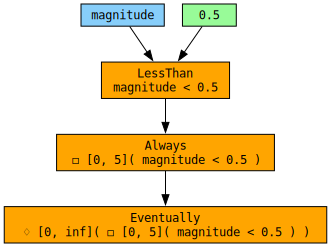

In [23]:
# nested temporal operators
# NOTE: temporal operatos pad signal with the value at the last time step
ϕ = Eventually(Always(distance_to_origin < 0.5, interval=[0, 5]))

if not distance_to_origin.reverse:
    distance_to_origin.flip(time_dim)   # reverse the time signal. Expressions help keep track of it for you.

ϕ(distance_to_origin);
make_stl_graph(ϕ)


### Until

In [24]:
ϕ = Until(avoid, reach)

if not distance_to_origin.reverse:
    distance_to_origin.flip(time_dim)   

if not distance_to_obstacle.reverse:
    distance_to_obstacle.flip(time_dim)  

ϕ((distance_to_obstacle, distance_to_origin));

AttributeError: 'Expression' object has no attribute 'shape'

### Multiple And (Or)

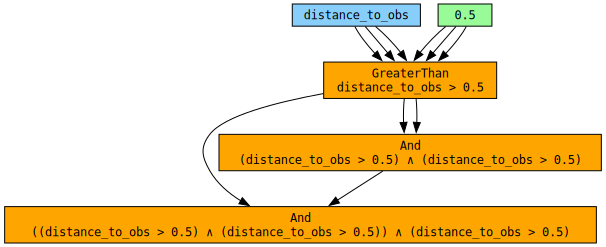

In [ ]:
ψ = distance_to_obstacle > 0.5
ϕ = ψ & ψ & ψ  # equivalent to (ψ & ψ) & ψ  this formula is redundant, but just demonstrating functionality
ϕ(((distance_to_obstacle,distance_to_obstacle), distance_to_obstacle));
make_stl_graph(ϕ)

# similarly, you can do this with Or --> ψ | ψ | ψ


### Implies

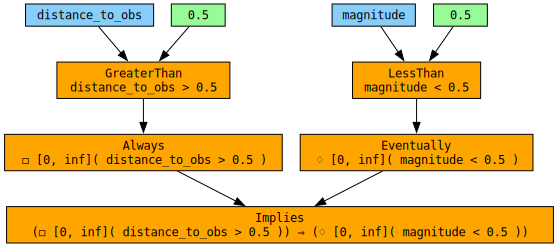

In [ ]:
ϕ = Implies(avoid, reach)
ϕ((distance_to_obstacle,distance_to_obstacle));
make_stl_graph(ϕ)
